# Britney Spears Recommender Model

### Creating your own recommender engine pool and generating recommendations from a seed track

In [220]:
#import packages
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Clean Britney playlist data

In [221]:
britney_df = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [222]:
britney_df =britney_df.drop_duplicates(subset='track_id')
britney_df.shape

(1193, 21)

In [223]:
britney_df = britney_df.dropna()
britney_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,-5.745,0,0.0307,0.2020,0.000131,0.4430,0.907,92.960,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,-3.914,0,0.1140,0.0249,0.025000,0.2420,0.924,143.040,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,-5.226,1,0.0622,0.0730,0.000000,0.0889,0.235,139.000,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,-3.131,1,0.0334,0.2500,0.000678,0.0723,0.382,113.324,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188,3K2lg4fY3CunPMeNlMnR32,Are You Gonna Be There,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,246586,2014-07-29,34,0.472,0.725,...,-5.442,1,0.0314,0.1980,0.000000,0.1390,0.409,86.030,3K2lg4fY3CunPMeNlMnR32,3K2lg4fY3CunPMeNlMnR32
1189,50haJiO2RhVsnTQ0Iu7lYS,For the Girl Who Has Everything - Radio Mix,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,236746,2014-07-29,28,0.579,0.617,...,-6.667,0,0.0291,0.1700,0.000000,0.0805,0.596,170.181,50haJiO2RhVsnTQ0Iu7lYS,50haJiO2RhVsnTQ0Iu7lYS
1190,0T9Aq8S8WKdXXh6EXM8cB8,If I'm Not the One,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,201413,2014-07-29,30,0.779,0.835,...,-5.290,0,0.0378,0.1620,0.000000,0.2550,0.936,104.016,0T9Aq8S8WKdXXh6EXM8cB8,0T9Aq8S8WKdXXh6EXM8cB8
1191,0S2AEPvmKGcdRYgqQP7MXq,Music of My Heart,6Ff53KvcvAj5U7Z1vojB5o,*NSYNC,3bhFoH4PFnY4ifK4981U8X,270893,2014-07-29,30,0.537,0.606,...,-7.029,1,0.0382,0.3920,0.000000,0.0903,0.411,112.080,0S2AEPvmKGcdRYgqQP7MXq,0S2AEPvmKGcdRYgqQP7MXq


### 2. Read training data 

In [224]:
genre_names = ["Jazz", "Pop", "Reggae", "Classical", "Country"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)

Jazz
Pop
Reggae
Classical
Country


In [225]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((479, 7), (8856, 22))

In [226]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [227]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8852, 22)

In [228]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8746, 22)

<AxesSubplot:>

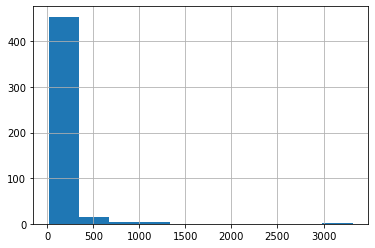

In [229]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

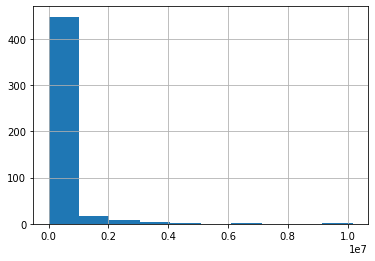

In [230]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [231]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

classical    0.272925
jazz         0.199634
pop          0.188772
reggae       0.186028
country      0.152641
Name: genre, dtype: float64

### 2. Refine the training data

In [232]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWVqfgj8NZEp1,Coffee Table Jazz,140,spotify,Spotify,2282279,jazz
1,37i9dQZF1DXbITWG1ZJKYt,Jazz Classics,100,spotify,Spotify,1905763,jazz
2,37i9dQZF1DX4wta20PHgwo,Late Night Jazz,80,spotify,Spotify,1852668,jazz
3,37i9dQZF1DX0SM0LYsmbMT,Jazz Vibes,350,spotify,Spotify,1775132,jazz
4,37i9dQZF1DWTbzY5gOVvKd,Jazzy Romance,60,spotify,Spotify,996283,jazz


In [233]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [234]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [235]:
tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()

count    2407.000000
mean        0.762869
std         0.174076
min         0.000000
25%         0.663653
50%         0.826147
75%         0.894885
max         1.000000
Name: loudness, dtype: float64

In [236]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()

count    2407.000000
mean        0.527422
std         0.154373
min         0.000000
25%         0.409178
50%         0.486401
75%         0.623485
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [237]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [238]:
tracks_df['genre'].value_counts()

jazz         712
pop          502
classical    473
reggae       466
country      254
Name: genre, dtype: int64

In [239]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,2wOlZrHUpRP9hQbqbV9Ae5,Together,0Cioop2zjxXxtcPUme7R46,Matthew Halsall,1fcREbFQfCqfwxXkxGgvV7,672520,2009-10-26,61,0.401,0.0236,...,0.978,0.57900,0.1020,0.163,0.516468,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,11.208667,2
1,2yiISACbYnL2hApy1ffKKs,Misty - Remastered 2020,6C65D20ASusYqHGSIktfED,Erroll Garner,41sYqKPEygmvQrLXKpzWJU,167121,2020-04-17,62,0.327,0.1450,...,0.945,0.88400,0.0910,0.136,0.836329,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,2.785350,2
2,2R1vQwYTC0sl93C6oyVuHC,Simplicity,0FAC6FNPb4LsY5uyp0xTWF,Edward Simon,4GDYdHheKfIOBMjqOgTK6k,309586,2020-10-09,58,0.493,0.1070,...,0.881,0.90600,0.1220,0.126,0.426777,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,5.159767,2
3,7zzaZggdFuadOs0R7SuJlp,My Ideal,5CSkWcdoRvgBQDwJTZZstJ,Jerry Bergonzi,2T8WUL1jRlaGIqj36oD5O5,219766,2021-01-15,45,0.526,0.0767,...,0.802,0.00195,0.0978,0.247,0.526978,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,3.662767,2
4,7LIFp3v3CaTCvcG6fmceIg,Clouds,7c7414LKkYnuDPlkrwDg9a,Portraits in Jazz,3LEyIlY9P6z9Mvp6dpxk9d,283650,2020-11-27,56,0.338,0.1650,...,0.977,0.31500,0.1220,0.174,0.356400,37i9dQZF1DWVqfgj8NZEp1,jazz,Coffee Table Jazz,4.727500,2


In [240]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{2: 'jazz', 3: 'pop', 4: 'reggae', 0: 'classical', 1: 'country'}

## 4. Train a KNN model

In [241]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


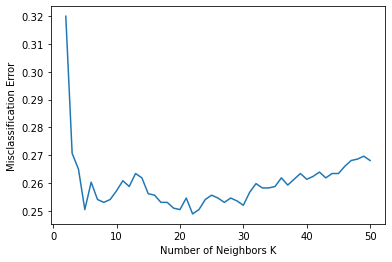

The optimal number of neighbors is 22 with score 75%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


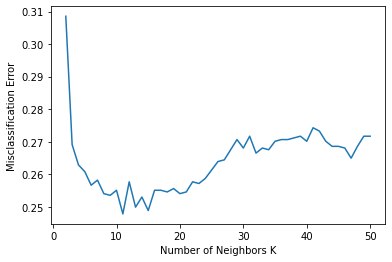

The optimal number of neighbors is 11 with score 75%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


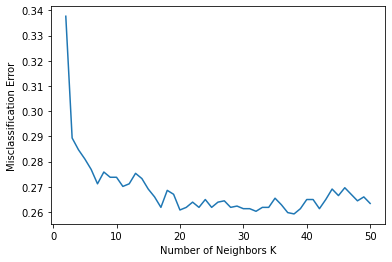

The optimal number of neighbors is 38 with score 74%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1925, 9)
Shape of y_Train:(1925,)
Shape of X_Test:(482, 9)
Shape of y_Test:(482,)
Finding best k...


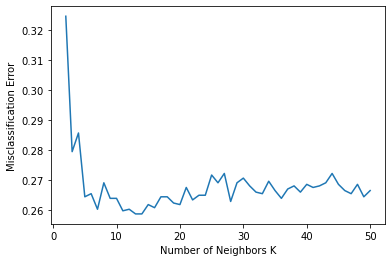

The optimal number of neighbors is 13 with score 74%


In [242]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [243]:
results_optimal_k

[22, 11, 38, 13]

### 5. Model Prediction

In [244]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [245]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [246]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 13


In [247]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.0,0.307692,0.000000,0.538462,0.153846
652,3xXBsjrbG1xQIm1xv1cKOt,One More Light,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,5Eevxp2BCbWq25ZdiXRwYd,255066,2017-05-19,72,0.593,0.200,...,0.170,0.193172,2,jazz,1.0,0.0,0.384615,0.000000,0.615385,0.000000
1483,2Uj9aeKOXPx4cgHrcd9401,Midnight Sky,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,2jBckVaJetRQeHQqgoLnh4,247968,2018-07-13,0,0.496,0.155,...,0.158,0.409887,2,jazz,1.0,0.0,0.076923,0.153846,0.538462,0.230769
393,60APt5N2NRaKWf5xzJdzyC,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,2HaqChIDc5go3qxVunBDK0,229160,2017-06-30,59,0.784,0.728,...,0.713,0.354379,4,reggae,1.0,0.0,0.000000,0.000000,0.000000,1.000000
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,0.191,0.150273,2,jazz,1.0,0.0,0.461538,0.153846,0.384615,0.000000


Check out tracks with highest assigned probability

In [248]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
3335,ROSÉ,On The Ground,pop,1.000000
652,Linkin Park,One More Light,jazz,1.000000
1483,Unique Salonga,Midnight Sky,jazz,1.000000
393,Calvin Harris,"Heatstroke (feat. Young Thug, Pharrell William...",reggae,1.000000
2753,Alexander 23,IDK You Yet,jazz,1.000000
3276,Ariana Grande,"34+35 Remix (feat. Doja Cat, Megan Thee Stalli...",reggae,1.000000
3285,Jeremy Zucker,this is how you fall in love,jazz,1.000000
547,Calvin Harris,Rollin (feat. Future & Khalid),reggae,1.000000
3079,Moira Dela Torre,Paubaya,jazz,1.000000
2698,Megan Thee Stallion,Savage Remix (feat. Beyoncé),reggae,1.000000


View histogram of predicted genre probabilities

<AxesSubplot:>

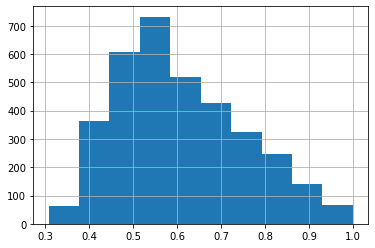

In [249]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [250]:
chart_tracks_df['predicted_genre'].value_counts()

pop          1348
reggae        968
country       631
jazz          523
classical      19
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [251]:
this_song = 'Lay Me Down'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('Lay Me Down')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
762,64GRDrL1efgXclrhVCeuA0,Lay Me Down,2wY79sveU1sp5g7SokKOiI,Sam Smith,0vrWqbRQEMKqhTGcDLQK7x,219535,2015-11-06,75,0.468,0.19,...,0.326,0.447624,2,jazz,0.923077,0.0,0.076923,0.0,0.384615,0.538462


In [252]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [253]:
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob
3335,2pn8dNVSpYnAtlKFC8Q0DJ,On The Ground,3eVa5w3URK5duf6eyVDbu9,ROSÉ,5BQcoDfcZ8aBcikYX9B7Ob,168085,2021-03-12,80,0.311,0.607,...,0.286,0.837618,3,pop,1.0,0.0,0.307692,0.000000,0.538462,0.153846
652,3xXBsjrbG1xQIm1xv1cKOt,One More Light,6XyY86QOPPrYVGvF9ch6wz,Linkin Park,5Eevxp2BCbWq25ZdiXRwYd,255066,2017-05-19,72,0.593,0.200,...,0.170,0.193172,2,jazz,1.0,0.0,0.384615,0.000000,0.615385,0.000000
1483,2Uj9aeKOXPx4cgHrcd9401,Midnight Sky,30mZI7Hw2MhoarTVYxfyZM,Unique Salonga,2jBckVaJetRQeHQqgoLnh4,247968,2018-07-13,0,0.496,0.155,...,0.158,0.409887,2,jazz,1.0,0.0,0.076923,0.153846,0.538462,0.230769
393,60APt5N2NRaKWf5xzJdzyC,"Heatstroke (feat. Young Thug, Pharrell William...",7CajNmpbOovFoOoasH2HaY,Calvin Harris,2HaqChIDc5go3qxVunBDK0,229160,2017-06-30,59,0.784,0.728,...,0.713,0.354379,4,reggae,1.0,0.0,0.000000,0.000000,0.000000,1.000000
2753,47EWMOElkkbMp5m9SBkx7d,IDK You Yet,6sFHvCyqklnJpXC9Nh1aag,Alexander 23,2BcmdSV1kyss7KFuSpobeS,184638,2020-04-09,51,0.629,0.306,...,0.191,0.150273,2,jazz,1.0,0.0,0.461538,0.153846,0.384615,0.000000


In [254]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob'],
      dtype='object')

In [255]:
#read data
britney_df=pd.read_csv("data/Britney_Spears_playlist_tracks_data.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
britney_df['loudness'] = scaler.fit_transform(britney_df[['loudness']])
britney_df['tempo'] =  scaler.fit_transform(britney_df[['tempo']])
britney_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,playlist_name
0,3MjUtNVVq3C8Fn0MP3zhXa,...Baby One More Time,26dSoYclwsYLMAKD3tpOr4,Britney Spears,3WNxdumkSMGMJRhEgK80qx,211066,1999-01-12,79,0.759,0.699,...,0.713767,0,0.0307,0.2020,0.000131,0.4430,0.907,0.218504,3MjUtNVVq3C8Fn0MP3zhXa,3MjUtNVVq3C8Fn0MP3zhXa
1,6I9VzXrHxO9rA9A5euc8Ak,Toxic,26dSoYclwsYLMAKD3tpOr4,Britney Spears,0z7pVBGOD7HCIB7S8eLkLI,198800,2003-11-13,82,0.774,0.838,...,0.807438,0,0.1140,0.0249,0.025000,0.2420,0.924,0.550393,6I9VzXrHxO9rA9A5euc8Ak,6I9VzXrHxO9rA9A5euc8Ak
2,6naxalmIoLFWR0siv8dnQQ,Oops!...I Did It Again,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,211160,2000-05-16,79,0.751,0.834,...,0.729166,0,0.0437,0.3000,0.000018,0.3550,0.894,0.232375,6naxalmIoLFWR0siv8dnQQ,6naxalmIoLFWR0siv8dnQQ
3,4fixebDZAVToLbUCuEloa2,Womanizer,26dSoYclwsYLMAKD3tpOr4,Britney Spears,2tve5DGwub1TtbX1khPX5j,224400,2008-12-02,78,0.724,0.695,...,0.740318,1,0.0622,0.0730,0.000000,0.0889,0.235,0.523619,4fixebDZAVToLbUCuEloa2,4fixebDZAVToLbUCuEloa2
4,6ic8OlLUNEATToEFU3xmaH,Gimme More,26dSoYclwsYLMAKD3tpOr4,Britney Spears,1ePkYcH5ZQCb1b4tQeiEDj,251240,2007-10-25,83,0.788,0.844,...,0.847496,1,0.0334,0.2500,0.000678,0.0723,0.382,0.353460,6ic8OlLUNEATToEFU3xmaH,6ic8OlLUNEATToEFU3xmaH


In [256]:
# Input seed track here
seed_track_name = 'Oops!...I Did It Again'

In [257]:
feature_cols = ['danceability', 'energy',\
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
       'liveness', 'valence', 'tempo']

In [258]:
# seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
# seed_track_data[feature_cols]

In [259]:
seed_track_data = pd.read_csv('data/Britney_Spears_playlist_tracks_data.csv')
seed_track_data = seed_track_data[feature_cols].mean()
seed_track_data

danceability          0.666693
energy                0.728810
loudness             -5.512785
speechiness           0.080287
acousticness          0.136064
instrumentalness      0.011355
liveness              0.182987
valence               0.600610
tempo               119.197300
dtype: float64

In [260]:
seed_track_data['track_id'] = '6naxalmIoLFWR0siv8dnQQ'
seed_track_data

danceability                      0.666693
energy                             0.72881
loudness                          -5.51279
speechiness                      0.0802873
acousticness                      0.136064
instrumentalness                 0.0113553
liveness                          0.182987
valence                            0.60061
tempo                              119.197
track_id            6naxalmIoLFWR0siv8dnQQ
dtype: object

In [261]:
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

In [262]:
#chart_tracks_df['euclidean_dist'] = chart_tracks_df.apply(lambda x: euclidean_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  #seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  #.flatten()[0], axis=1)
#get top 10 nearest to seed_track_data>>> #ALL
#recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('euclidean_dist')
#recommendation_df[['track_name','artist_name','euclidean_dist','predicted_genre']+feature_cols]

In [263]:
#chart_tracks_df['manhattan_dist'] = chart_tracks_df.apply(lambda x: manhattan_distances(x[feature_cols].values.reshape(-1, 1),\
                                                                  #seed_track_data[feature_cols].values.reshape(-1, 1))\
                                                                  #.flatten()[0], axis=1)
#get top 10 nearest to seed_track_data>>>ALL
#recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('manhattan_dist')
#recommendation_df[['track_name','artist_name','manhattan_dist','predicted_genre']+feature_cols]

In [264]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head()

#get top 10 nearest to seed_track_data>>>ALL
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3244,Snowfall on Christmas Eve,The Rossman Ensemble,0.308364,country,0.575,0.411,0.536663,0.0722,0.0251,0.069300,0.0751,0.4620,1.000000
1600,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.341179,country,0.264,0.273,0.638649,0.0312,0.5350,0.000000,0.2070,0.3150,0.911930
1781,Demonyo,juan karlos,0.343813,pop,0.415,0.508,0.617441,0.0363,0.0509,0.016200,0.1030,0.1140,0.837889
1529,"Closer You and I - From ""Loving in Tandem""",Michael Pangilinan,0.359664,pop,0.207,0.535,0.713613,0.0414,0.2010,0.000000,0.3360,0.2640,0.906589
3412,Untouchable (Taylor’s Version),Taylor Swift,0.359990,pop,0.393,0.531,0.742600,0.0329,0.0181,0.000000,0.1690,0.2240,0.909555
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,Bambi,BAEKHYUN,0.979510,country,0.438,0.632,0.810768,0.0417,0.4340,0.000000,0.2140,0.3860,0.054628
1373,Girls Like You,Maroon 5,0.980394,country,0.601,0.469,0.699816,0.0563,0.5710,0.000001,0.1280,0.3990,0.047896
1770,A Million Dreams,Ziv Zaifman,1.008450,jazz,0.265,0.312,0.514268,0.0569,0.2430,0.000000,0.0893,0.0998,0.013383
1108,A Million Dreams,Ziv Zaifman,1.008450,jazz,0.265,0.312,0.514268,0.0569,0.2430,0.000000,0.0893,0.0998,0.013383


In [293]:
recommendation_df.sort_values(by="cosine_dist", ascending=True)

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob,cosine_dist
3244,4IfAArwYrxwGvwSHMGPRFi,Snowfall on Christmas Eve,7MmIC8lbUdmL6c05M63KF6,The Rossman Ensemble,4Qu2wlwTSvpOpkNTIptIVx,116093,2020-09-30,31,0.575,0.411,...,1.000000,1,country,0.307692,0.0,0.000000,0.000000,0.461538,0.538462,0.308364
1600,7aW2GrNlteWTwQZxX6LNjT,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0v4UIlXB8pda8iP9vUdV25,219689,2018-08-17,56,0.264,0.273,...,0.911930,1,country,0.384615,0.0,0.076923,0.000000,0.153846,0.769231,0.341179
1781,1WXs4O7mBxXglHJPwYweHq,Demonyo,0a4r2EnsevvHCukoJ1xFwJ,juan karlos,67vvDiZLNyjNQ1gU6El7GC,218000,2017-01-27,59,0.415,0.508,...,0.837889,3,pop,0.923077,0.0,0.076923,0.000000,0.923077,0.000000,0.343813
1529,0GuAFGEkbWayjhWdlYlr7K,"Closer You and I - From ""Loving in Tandem""",1t2caVgyabZrVDAlmMGraV,Michael Pangilinan,5mkhEWVxQqBCivhl4hMYtx,196067,2017-09-15,50,0.207,0.535,...,0.906589,3,pop,0.692308,0.0,0.000000,0.000000,0.307692,0.692308,0.359664
3412,0tQ9vBYpldCuikPsbgOVKA,Untouchable (Taylor’s Version),06HL4z0CvFAxyc27GXpf02,Taylor Swift,4hDok0OAJd57SGIT8xuWJH,312107,2021-04-09,71,0.393,0.531,...,0.909555,3,pop,0.846154,0.0,0.615385,0.000000,0.384615,0.000000,0.359990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3375,60VaORSJ5x1D4ZPSc0g2En,Bambi,4ufh0WuMZh6y4Dmdnklvdl,BAEKHYUN,5xOx4mWABbTj0qWyZC4q1p,213053,2021-03-30,74,0.438,0.632,...,0.054628,1,country,0.461538,0.0,0.692308,0.076923,0.230769,0.000000,0.979510
1373,306akccFCc6D29uDoBDt7t,Girls Like You,04gDigrS5kc9YWfZHwBETP,Maroon 5,1qvLKCq4Xh355Fq0VswCpH,215229,2017-11-03,0,0.601,0.469,...,0.047896,1,country,0.384615,0.0,0.153846,0.000000,0.076923,0.769231,0.980394
1108,0RoA7ObU6phWpqhlC9zH4Z,A Million Dreams,2cQr2KbzdRtIFlfbHGnNsL,Ziv Zaifman,7ayBZIe1FHkNv0T5xFCX6F,269453,2017-12-08,75,0.265,0.312,...,0.013383,2,jazz,0.384615,0.0,0.076923,0.000000,0.846154,0.076923,1.008450
1770,11DnDeWTQuv3GIH0XHT2pl,A Million Dreams,2cQr2KbzdRtIFlfbHGnNsL,Ziv Zaifman,1oqnHxrKI3Gq8MKgAGDtMr,269453,2017-12-08,35,0.265,0.312,...,0.013383,2,jazz,0.384615,0.0,0.461538,0.000000,0.538462,0.000000,1.008450


In [274]:
chart_tracks_df.columns

Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
       'duration', 'release_date', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
       'predicted_classical_prob', 'predicted_country_prob',
       'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_reggae_prob',
       'cosine_dist'],
      dtype='object')

In [266]:
#chart_tracks_df[['euclidean_dist','manhattan_dist','cosine_dist']].hist()

Modify similarity criteria

### Getting the Competitors

In [267]:
# read and process the charts dataset
charts_df = pd.read_csv('spotify_daily_charts.csv')
#transform date column into a datetime column
charts_df['date'] = pd.to_datetime(charts_df['date'])
charts_df.head()

,date,position,track_id,track_name,artist,streams
0,2017-01-01,1,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,Bruno Mars,185236
1,2017-01-01,2,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,180552
2,2017-01-01,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,158720
3,2017-01-01,4,2rizacJSyD9S1IQUxUxnsK,All We Know,The Chainsmokers,130874
4,2017-01-01,5,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,129656


In [268]:
charts_df['year'] = charts_df['date'].dt.year
charts_df

,date,position,track_id,track_name,artist,streams,year
0,2017-01-01,1,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,Bruno Mars,185236,2017
1,2017-01-01,2,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,James Arthur,180552,2017
2,2017-01-01,3,7BKLCZ1jbUBVqRi2FVlTVw,Closer,The Chainsmokers,158720,2017
3,2017-01-01,4,2rizacJSyD9S1IQUxUxnsK,All We Know,The Chainsmokers,130874,2017
4,2017-01-01,5,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,Maroon 5,129656,2017
...,...,...,...,...,...,...,...
319595,2021-05-20,196,45bE4HXI0AwGZXfZtMp8JR,you broke me first,Tate McRae,26991,2021
319596,2021-05-20,197,70eFcWOvlMObDhURTqT4Fv,Beautiful People (feat. Khalid),Ed Sheeran,26893,2021
319597,2021-05-20,198,1lkvpmrCaXK8QtliFDcHBO,Bubbly,Colbie Caillat,26863,2021
319598,2021-05-20,199,50kpGaPAhYJ3sGmk6vplg0,Love Yourself,Justin Bieber,26728,2021


In [269]:
#artist_streams_df= charts_df.groupby(["artist", "year"]).sum()[["streams"]]
#avg_per_yr= artist_streams_df.groupby("artist").mean()[["streams"]].sort_values(by="streams", ascending= False).reset_index()
#avg_per_yr[(avg_per_yr["streams"]>100000) & (avg_per_yr["artist"]== "The Rossman Ensemble")]
#avg_per_yr[avg_per_yr["artist"]== "The Rossman Ensemble"]
#artist_streams_df
#artist_streams_df[artist_streams_df["streams"]>100000]

In [270]:

charts_df = charts_df.rename(columns={'artist':'artist_name'})
df_merge = recommendation_df.merge(charts_df, on='track_id', how='left').sort_values(by= "cosine_dist", ascending= True)
df_merge.dropna()

,track_id,track_name_x,artist_id,artist_name_x,album_id,duration,release_date,popularity,danceability,energy,...,predicted_jazz_prob,predicted_pop_prob,predicted_reggae_prob,cosine_dist,date,position,track_name_y,artist_name_y,streams,year
0,4IfAArwYrxwGvwSHMGPRFi,Snowfall on Christmas Eve,7MmIC8lbUdmL6c05M63KF6,The Rossman Ensemble,4Qu2wlwTSvpOpkNTIptIVx,116093,2020-09-30,31,0.575,0.411,...,0.0,0.461538,0.538462,0.308364,2020-12-24,181,Snowfall on Christmas Eve,The Rossman Ensemble,35859,2020
140,7aW2GrNlteWTwQZxX6LNjT,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0v4UIlXB8pda8iP9vUdV25,219689,2018-08-17,56,0.264,0.273,...,0.0,0.153846,0.769231,0.341179,2019-01-15,97,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,34679,2019
141,7aW2GrNlteWTwQZxX6LNjT,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0v4UIlXB8pda8iP9vUdV25,219689,2018-08-17,56,0.264,0.273,...,0.0,0.153846,0.769231,0.341179,2019-01-16,89,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,36747,2019
142,7aW2GrNlteWTwQZxX6LNjT,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0v4UIlXB8pda8iP9vUdV25,219689,2018-08-17,56,0.264,0.273,...,0.0,0.153846,0.769231,0.341179,2019-01-17,92,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,37259,2019
143,7aW2GrNlteWTwQZxX6LNjT,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,0v4UIlXB8pda8iP9vUdV25,219689,2018-08-17,56,0.264,0.273,...,0.0,0.153846,0.769231,0.341179,2019-01-18,96,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,35778,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319395,6TbDpqKCksZNJjriFhPum8,Could I Love You Any More (feat. Jason Mraz),2Xr7M6vawpp6zwKOMU7iBU,Reneé Dominique,1LYpuMBu82KpTYr6fALY3G,189500,2019-05-31,62,0.288,0.371,...,0.0,0.846154,0.000000,1.023068,2019-09-12,46,Could I Love You Any More (feat. Jason Mraz),Reneé Dominique,72679,2019
319396,6TbDpqKCksZNJjriFhPum8,Could I Love You Any More (feat. Jason Mraz),2Xr7M6vawpp6zwKOMU7iBU,Reneé Dominique,1LYpuMBu82KpTYr6fALY3G,189500,2019-05-31,62,0.288,0.371,...,0.0,0.846154,0.000000,1.023068,2019-09-13,48,Could I Love You Any More (feat. Jason Mraz),Reneé Dominique,71543,2019
319397,6TbDpqKCksZNJjriFhPum8,Could I Love You Any More (feat. Jason Mraz),2Xr7M6vawpp6zwKOMU7iBU,Reneé Dominique,1LYpuMBu82KpTYr6fALY3G,189500,2019-05-31,62,0.288,0.371,...,0.0,0.846154,0.000000,1.023068,2019-09-14,47,Could I Love You Any More (feat. Jason Mraz),Reneé Dominique,67805,2019
319387,6TbDpqKCksZNJjriFhPum8,Could I Love You Any More (feat. Jason Mraz),2Xr7M6vawpp6zwKOMU7iBU,Reneé Dominique,1LYpuMBu82KpTYr6fALY3G,189500,2019-05-31,62,0.288,0.371,...,0.0,0.846154,0.000000,1.023068,2019-09-04,46,Could I Love You Any More (feat. Jason Mraz),Reneé Dominique,70301,2019


In [275]:
track_id_unique=df_merge.groupby(["artist_name_x","year"]).nunique("track_id")[["track_id"]].reset_index()
track_id_unique2=track_id_unique.groupby("artist_name_x").mean()[["track_id"]].reset_index()
track_id_unique2.sort_values(by="track_id", ascending= False)

,artist_name_x,track_id
702,Taylor Swift,35.0
439,Linkin Park,32.0
87,BTS,25.4
411,LANY,21.8
62,Ariana Grande,19.0
...,...,...
318,James Blunt,1.0
317,James Bay,1.0
315,Jake Zyrus,1.0
314,Jack Stauber,1.0


In [290]:
competitors= df_merge.groupby("artist_name_x").agg({'streams' : "mean",'cosine_dist' : "mean"}).sort_values(by="cosine_dist", ascending= True).reset_index()

competitors_track_id = track_id_unique2.merge(competitors, on='artist_name_x', how='left').sort_values(by= "cosine_dist", ascending= True)

competitors_track_id[(competitors_track_id["streams"]>=107000) & (competitors_track_id["track_id"]>=3)].sort_values(by="cosine_dist", ascending= False)


,artist_name_x,track_id,streams,cosine_dist
573,Pink Sweat$,3.5,173525.740741,0.827079
780,Zack Tabudlo,4.0,160640.945946,0.692063
495,Maximillian,3.0,115150.829716,0.623565
552,Olivia Rodrigo,4.0,191311.251282,0.577280
